In [39]:
import kagglehub

path = kagglehub.dataset_download("iabhishekofficial/mobile-price-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/alesvale/.cache/kagglehub/datasets/iabhishekofficial/mobile-price-classification/versions/1


#### Q5
5. Creare una pipeline in cui gli attributi int_memory, ram e talk_time sono scalati in <br/>
modo che abbiano media 0 e varianza 1, gli attributi mobile_wt e battery_power sono <br/>
discretizzati in 5 intervalli, e tutti gli altri attributi sono lasciati invariati. La pipeline deve <br/> 
applicare il modello DecisionTree. Valutare l’accuratezza della classificazione attraverso <br/>
accuracy e confusion matrix. <br/>

In [40]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
import matplotlib.pyplot as plt 

In [41]:
df = pd.read_csv(f"{path}/train.csv", sep=',')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [42]:
# Scalati in modo che abbiano media 0 e varianza 1 (standardizzati)
scaled_columns = [
    'int_memory',
    'ram',
    'talk_time'
]

# Discretizzati in 5 bin
discretized_columns = [
    'mobile_wt',
    'battery_power'
]

column_transformer = ColumnTransformer(transformers=[
    ('scaled', StandardScaler(), scaled_columns),
    ('discretized', KBinsDiscretizer(n_bins=5, encode='ordinal', quantile_method='linear'), discretized_columns)
], remainder='passthrough')

model = DecisionTreeClassifier(max_depth=5)

pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('classifier', model)
])

In [43]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price_range'])
y = df['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

pipeline.fit(X=X_train, y=y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaled', ...), ('discretized', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the d

Accuracy: 0.83


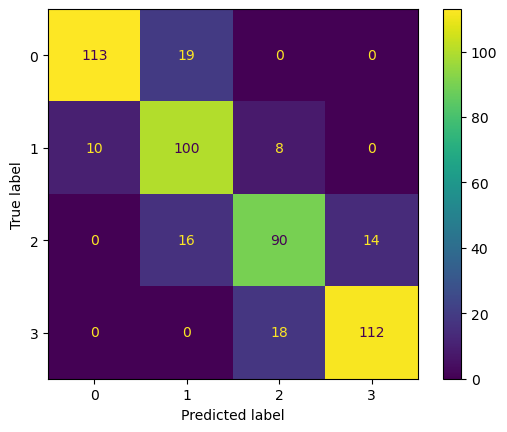

In [44]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


#### Q6
6. Aggiungere alla pipeline del punto 5 la funzione SelectKBest per selezionare K feature tra <br/>
quelle restituite dalla pipeline del punto 5. Utilizzare la funzione di gridSearchCV per <br/>
selezionare il valore migliore di K, il numero migliore di bin in cui discretizzare i valori di <br/> 
mobile_wt e battery_power e i valori degli iperparametri criterion e <br/>
min_samples_leaf del modello DecisionTree (scegliere a piacere alcuni valori). <br/>

Accuracy: 0.832
best params: {cv.best_params_}


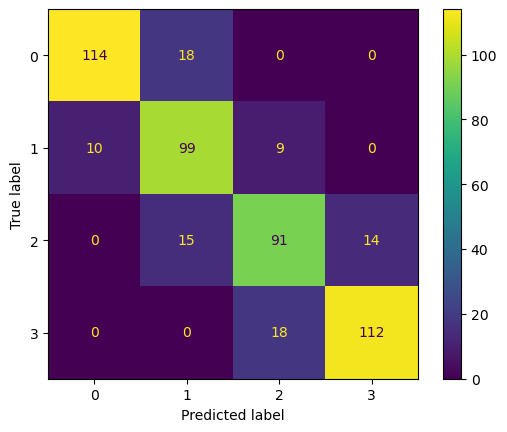

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

pipeline_2 = Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('selectkbest', SelectKBest(k=10)),
    ('classifier', model)
])

param_grid = {
    'selectkbest__k': [3, 5, 10],
    'preprocessing__discretized__n_bins': [5, 10, 15],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_leaf': [1,2,3]
}

cv = GridSearchCV(pipeline_2, param_grid=param_grid, cv=10)

cv.fit(X=X_train, y=y_train)
y_predicted = cv.predict(X_test)

accuracy_2 = accuracy_score(y_test, y_predicted)
print(f"Accuracy: {accuracy_2}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)

In [52]:
print(f'best params: {cv.best_params_}')

best params: {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 2, 'preprocessing__discretized__n_bins': 5, 'selectkbest__k': 5}


#### Q7
7. Creare una nuova pipeline che applica la decomposizione TruncatedSVD al dataset <br/>
iniziale e aggiunge le componenti ottenute alla pipeline del punto 5. Valutare il valore <br/>
migliore per il numero di componenti di TruncatedSVD tra 2, 4 e 6. <br/>

In [55]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion

In [58]:
combined_features = FeatureUnion(transformer_list=[
    ('preprocessing', column_transformer),
    ('svd', TruncatedSVD(n_components=2))
])

pipeline_3 = Pipeline(steps=[
    ('features', combined_features),
    ('classifier', model)
])

param_grid = {
    'features__svd__n_components': [2, 4, 6] 
}

cv = GridSearchCV(pipeline_3, param_grid)

cv.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...ax_depth=5))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'features__svd__n_components': [2, 4, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold

Accuracy: 0.928
best params: {'features__svd__n_components': 2}


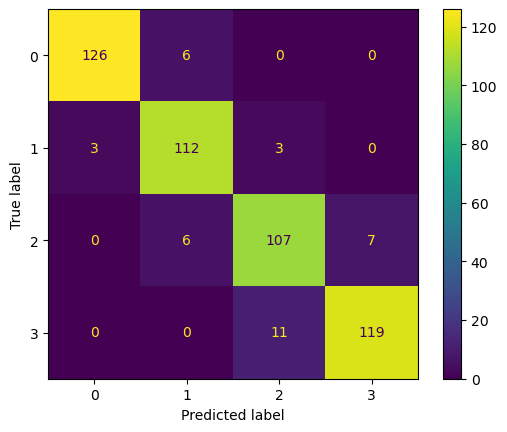

In [57]:
y_predicted = cv.predict(X_test)

accuracy_3 = accuracy_score(y_test, y_predicted)
print(f"Accuracy: {accuracy_3}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)

print(f"best params: {cv.best_params_}")